In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import pylab 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time

In [2]:
%store -r last_pymnt_d_null
%store -r last_credit_pull_d_null
%store -r earliest_cr_line_null

In [3]:
# #For Colab:

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
uploaded = 'accepted_clean.csv'

# #For Colab: 
# uploaded = '/content/drive/MyDrive/Data/accepted_clean.csv'

In [5]:
#parse_dates wont recognize dates as datetime objects, will cast 
df_clean = pd.read_csv(uploaded)
df_clean.shape

(2247883, 87)

In [6]:
#Flooring received late fees at zero vs rounding errors of basically zero

df_clean.iloc[df_clean[df_clean['total_rec_late_fee'] < 0].index,df_clean.columns.get_loc('total_rec_late_fee')] = 0

In [7]:
df_clean['issue_d'] = pd.to_datetime(df_clean['issue_d'])
df_clean['earliest_cr_line'] = pd.to_datetime(df_clean['earliest_cr_line'])
df_clean['last_pymnt_d'] = pd.to_datetime(df_clean['last_pymnt_d'])
df_clean['last_credit_pull_d'] = pd.to_datetime(df_clean['last_credit_pull_d'])

In [8]:
#Setting fields with a last credit_pull_d beyond march 2019 to march 2019

#Setting the relative point for dates as of Q1 2019 since dataset collection ends as of Q4 2018 (and confirmed no material # of dates beyond 3/1/19). Setting date to current doesn't make as much sense.

rel_date = datetime.datetime(2019,3,1)

date_idxs = df_clean[df_clean['last_credit_pull_d'] > rel_date]['last_credit_pull_d'].index
df_clean.loc[date_idxs,'last_credit_pull_d'] = rel_date

In [9]:
#Creating the relative date fields 

dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d','rel_date']
rel_dates_list = [i+'_rel' for i in dates]
agg_dates = dates + rel_dates_list

df_clean['rel_date'] = rel_date

for i in dates:
  df_clean[i+'_rel'] = (df_clean['rel_date'] - df_clean[i]).astype('timedelta64[M]')


In [10]:
#Find the dates that were nulls and match IDs so we can fill those '0' with nulls after the timedeltas[M]

# last_pymnt_d_null
# last_credit_pull_d_null
# earliest_cr_line_null

last_pymnt_idxs = [df_clean[df_clean['id']==int(i)].index[0] for i in last_pymnt_d_null]
last_credit_pull_idxs = [df_clean[df_clean['id']==int(i)].index[0] for i in last_credit_pull_d_null]
earliest_cr_line_idxs = [df_clean[df_clean['id']==int(i)].index[0] for i in earliest_cr_line_null]

In [11]:
# print(len(last_pymnt_idxs) == len(last_pymnt_d_null))
# print(len(last_credit_pull_idxs) == len(last_credit_pull_d_null))
# print(len(earliest_cr_line_idxs) == len(earliest_cr_line_null))

In [12]:
df_clean.iloc[last_pymnt_idxs,df_clean.columns.get_loc('last_pymnt_d')] = np.nan
df_clean.iloc[last_pymnt_idxs,df_clean.columns.get_loc('last_pymnt_d_rel')] = np.nan

df_clean.iloc[last_credit_pull_idxs,df_clean.columns.get_loc('last_credit_pull_d')] = np.nan
df_clean.iloc[last_credit_pull_idxs,df_clean.columns.get_loc('last_credit_pull_d_rel')] = np.nan

df_clean.iloc[earliest_cr_line_idxs,df_clean.columns.get_loc('earliest_cr_line')] = np.nan
df_clean.iloc[earliest_cr_line_idxs,df_clean.columns.get_loc('earliest_cr_line_rel')] = np.nan


In [13]:
#Storing columns that will ultimately be removed from dataset

ids = df_clean['id'] #wont provide insight into the model
title = df_clean['emp_title'] #~25% of categorical inputs are unique
loan_status = df_clean['loan_status'] #is the target
loan_status_adj = df_clean['loan_status_adj'] #is the target
issue_date = df_clean['issue_d'] #Converted to relative fields
earliest_credit = df_clean['earliest_cr_line'] #Converted to relative fields
last_payment = df_clean['last_pymnt_d'] #Converted to relative fields
last_pull = df_clean['last_credit_pull_d'] #Converted to relative fields
sub_grade = df_clean['sub_grade'] #Have grade. Although more granular, would only encode the top 10 most common grades vs one-hot encoding all letter grades 

drop_features = ['id','emp_title','issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d','rel_date_rel','rel_date','loan_status','loan_status_adj','sub_grade']

In [14]:
df_clean = df_clean.drop(drop_features,axis=1)

In [15]:
categorical = df_clean.select_dtypes('O').columns
numerical = df_clean.select_dtypes('float64').columns

df_numerical = df_clean[numerical]
df_categorical = df_clean[categorical]

In [16]:
#Will need to handle missing values

numerical_missing = []

for i in df_numerical.columns:
    if df_numerical[i].isnull().sum()>0:
        numerical_missing.append(i)
        print(f'{i}: {df_numerical[i].isnull().sum()}\n')

emp_length: 145871

annual_inc: 1659

dti: 3418

delinq_2yrs: 29

inq_last_6mths: 30

open_acc: 29

pub_rec: 29

revol_util: 1791

total_acc: 29

last_fico_range_high: 235

last_fico_range_low: 37274

collections_12_mths_ex_med: 145

acc_now_delinq: 29

tot_coll_amt: 70276

tot_cur_bal: 70276

total_rev_hi_lim: 70276

acc_open_past_24mths: 50030

avg_cur_bal: 71244

bc_open_to_buy: 74768

bc_util: 75893

chargeoff_within_12_mths: 145

delinq_amnt: 29

mo_sin_old_il_acct: 138668

mo_sin_old_rev_tl_op: 70277

mo_sin_rcnt_rev_tl_op: 70277

mo_sin_rcnt_tl: 70276

mort_acc: 50030

mths_since_recent_bc: 73266

mths_since_recent_inq: 294246

num_accts_ever_120_pd: 70276

num_actv_bc_tl: 70276

num_actv_rev_tl: 70276

num_bc_sats: 58590

num_bc_tl: 70276

num_il_tl: 70276

num_op_rev_tl: 70276

num_rev_accts: 70277

num_rev_tl_bal_gt_0: 70276

num_sats: 58590

num_tl_120dpd_2m: 152937

num_tl_30dpd: 70276

num_tl_90g_dpd_24m: 70276

num_tl_op_past_12m: 70276

pct_tl_nvr_dlq: 70431

percent_bc_

In [17]:
#Will need to handle missing values in title, zip_code

categorical_missing = []

for i in df_categorical.columns:
    if df_categorical[i].isnull().sum()>0:
        categorical_missing.append(i)
        print(f'{i}: {df_categorical[i].isnull().sum()}\n')

title: 23154

zip_code: 1



In [18]:
print(len(numerical_missing))
print(len(categorical_missing))

54
2


In [19]:
#Ensure no single value features still left in the dataset

single_value = [i for i,v in enumerate(df_clean.nunique()) if v == 1]
len(single_value)

0

In [20]:
#Get list of features to encode
print(df_categorical.nunique().sort_values(ascending=False))

one_hot_list = list(df_categorical.iloc[:,[i for i,v in enumerate(df_categorical.nunique()) if v <= 10]].columns)
encode_ten_plus = list(df_categorical.iloc[:,[i for i,v in enumerate(df_categorical.nunique()) if v > 10]].columns)

title                  63060
zip_code                 956
addr_state                51
purpose                   14
grade                      7
home_ownership             6
verification_status        3
pymnt_plan                 2
initial_list_status        2
application_type           2
hardship_flag              2
disbursement_method        2
target                     2
dtype: int64


In [21]:
#Ordinal features: grade, sub_grade [ultimately will only utilize one]

ord_encode = ['grade']
one_hot_list.remove('grade')

In [22]:
#Encoding the top 10 most commmon categorical values for those with counts > 10 to limit feature space

purpose_encode = list(df_clean[encode_ten_plus[0]].value_counts().sort_values(ascending=False).head(10).index.to_list())
title_encode = list(df_clean[encode_ten_plus[1]].value_counts().sort_values(ascending=False).head(10).index.to_list())
zip_code = list(df_clean[encode_ten_plus[2]].value_counts().sort_values(ascending=False).head(10).index.to_list())
addr_state = list(df_clean[encode_ten_plus[3]].value_counts().sort_values(ascending=False).head(10).index.to_list())

encode_ten_list = [purpose_encode,title_encode,zip_code,addr_state]

In [23]:
df1 = df_clean[encode_ten_plus].copy()

for i in np.array(encode_ten_list).flatten():
    if np.where(np.array(encode_ten_list).flatten()==i)[0][0] < 10:
        var = encode_ten_plus[0]
        df1[var+'_'+i] = np.where(df1[var]==i,1,0)
    elif np.where(np.array(encode_ten_list).flatten()==i)[0][0] < 20:
        var = encode_ten_plus[1]
        df1[var+'_'+i] = np.where(df1[var]==i,1,0)
    elif np.where(np.array(encode_ten_list).flatten()==i)[0][0] < 30:
        var = encode_ten_plus[2]
        df1[var+'_'+i] = np.where(df1[var]==i,1,0)
    elif np.where(np.array(encode_ten_list).flatten()==i)[0][0] < 40:
        var = encode_ten_plus[3]
        df1[var+'_'+i] = np.where(df1[var]==i,1,0)
    else: 
        df1['Error'] = np.where(df1['Error']==i,"Check",0)

# #Check
# for j in range(len(encode_ten_plus)):
#     for i in range(len(df1.filter(regex=encode_ten_plus[j]).groupby(encode_ten_plus[j]).mean().columns)):
#         print(f'{i}: {df1.filter(regex=encode_ten_plus[j]).groupby(encode_ten_plus[j]).mean().iloc[:,i-1].sum()}')

In [24]:
df1.drop(encode_ten_plus,axis=1,inplace=True)
df_encoded = pd.concat([df_clean,df1],axis=1)
df_encoded.drop(encode_ten_plus,axis=1,inplace=True)

In [25]:
grade_map = {  'A':1,
               'B':2,
               'C':3,
               'D':4,
               'E':5,
               'F':6,
               'G':7
}

df_encoded['grade_ord'] = df_encoded.grade.map(grade_map)
#df_encoded[['grade','grade_ord']].head(10)

# Pipeline

In [26]:
#Build pipeline, RepeatedStratified cv fold: n_splits=10, n_repeats=3
    #standardize & transform data
    #impute missing values
    #encode categorical/ordinal
    #remove outliters
    #select features 

In [50]:
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
# from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import RandomOverSampler

In [67]:
X = df_encoded.loc[:,df_encoded.columns. drop(['grade','target'])].sample(n=10000, random_state=42)
y = df_encoded.loc[:,df_encoded.columns == 'target'].sample(n=10000, random_state=42).to_numpy().ravel()

# X = df_encoded.loc[:,df_encoded.columns.drop(['grade','target'])]
# y = df_encoded.loc[:,df_encoded.columns == 'target'].to_numpy().ravel()

y = 1 - LabelEncoder().fit_transform(y)

In [72]:
df_encoded.loc[:,df_encoded.columns.drop(['grade','target'])].to_csv('X.csv',index=False)
pd.Series(1- LabelEncoder().fit_transform(df_encoded.loc[:,df_encoded.columns == 'target'].to_numpy().ravel())).to_frame().to_csv('y.csv',index=False)

In [73]:
num_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('norm', PowerTransformer(method='yeo-johnson', standardize=True))
])

#BOXCOX TRANSFORM
# num_transform = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
#     ('norm', PowerTransformer(method='box-cox', standardize=True))])

cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# CONSTANT CAT. IMPUTER
# cat_transform = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
#     ('onehot',OneHotEncoder(handle_unknown='ignore'))
# ])


In [74]:
num_ix = X.select_dtypes(['float64','int64']).columns
cat_ix = X.select_dtypes(['O']).columns

In [75]:
t= [
    ('categorical',cat_transform,cat_ix),
    ('numerical',num_transform,num_ix),
]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=42, stratify=y)

In [51]:
num_transform_chi2 = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])


cat_transform_chi2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

t_chi2= [
    ('categorical',cat_transform_chi2,cat_ix),
    ('numerical',num_transform_chi2,num_ix),
]

ct_chi2 = ColumnTransformer(transformers=t_chi2,remainder='passthrough')

cv_chi2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [52]:
X2 = SelectKBest(chi2, k=60)

pipe_chi2 = Pipeline(steps=[
    ('preprocess',ct_chi2),
    ('chi2', X2)
])

pipe_chi2.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['home_ownership', 'verification_status', 'pymnt_plan',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement...
                                                  Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       ...
       'addr_state_TX', 'addr_state_NY', 'addr_state_FL', 'ad

In [76]:
RF = RandomForestClassifier()

pipe_RF = Pipeline(steps=[
    ('preprocess',ct),
    ('RF', RF)
])

In [77]:
metric = make_scorer(fbeta_score, beta=2)

scores = cross_val_score(pipe_RF, X, y, scoring=metric, cv=cv, n_jobs=-1) 
print('Mean F2 Score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
print()
print(scores)

Mean F2 Score: 0.864 (0.024)

[0.84814216 0.82792208 0.87761675 0.89314195 0.87719298 0.86956522
 0.81451613 0.8681672  0.89456869 0.87955626 0.85483871 0.87859425
 0.888      0.864      0.8681672  0.86012862 0.83064516 0.864
 0.90764331 0.83467095 0.88658147 0.90620032 0.8373591  0.84814216
 0.83467095 0.82658023 0.872      0.888      0.86012862 0.86783439]


In [80]:
pd.Series(y).value_counts(normalize=True)

0    0.8719
1    0.1281
dtype: float64

In [81]:
LR = LogisticRegression(solver='liblinear')

fs = SelectKBest(score_func=f_classif)
#fs = SelectKBest(score_func=mutual_info_classif, k ='all')
#fs = SelectKBest(score_func=chi2)

pipe_FS = Pipeline(steps=[
    ('preprocess',ct),
   ('anova',fs),
    ('LR', LR)
])

grid = dict()
grid['anova__k'] = [i+1 for i in range(50)]
# define the grid search
search = GridSearchCV(pipe_FS, grid, scoring=metric, cv=cv, n_jobs=-1) 
# perform the search

results = search.fit(X,y)

print()
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Mean Accuracy: 0.885
Best Config: {'anova__k': 18}


In [85]:
LR = LogisticRegression(solver='liblinear')

# fs = SelectKBest(score_func=f_classif)
fs = SelectKBest(score_func=mutual_info_classif)
#fs = SelectKBest(score_func=chi2)

pipe_FS = Pipeline(steps=[
    ('preprocess',ct),
   ('anova',fs),
    ('LR', LR)
])

grid = dict()
grid['anova'] = [i+1 for i in range(60)]
# define the grid search
search = GridSearchCV(pipe_FS, grid, scoring=metric, cv=cv, n_jobs=-1) 
# perform the search

results = search.fit(X,y)

print()
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '53' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cx

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be esti

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '19' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_ste

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '21' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator f

    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '24' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '32' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cx

TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '36' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '52' (type <class 'int'>) doesn't)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last

NotFittedError: All estimators failed to fit

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 184, in _fit
    self._validate_steps()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 133, in _validate_steps
    raise TypeError(
TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both

In [149]:
LR = LogisticRegression(solver='liblinear')

# fs = SelectKBest(score_func=f_classif)
# fs = SelectKBest(score_func=mutual_info_classif)
fs = SelectKBest(score_func=chi2)

pipe_FS = Pipeline(steps=[
    ('preprocess',ct),
   ('anova',fs),
    ('LR', LR)
])

grid = dict()
grid['anova__k'] = [i+1 for i in range(60)]
# define the grid search
search = GridSearchCV(pipe_FS, grid, scoring=metric, cv=cv, n_jobs=-1) 
# perform the search

results = search.fit(X,y)

print()
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 210, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, i

KeyboardInterrupt: 

In [39]:
fs = SelectKBest(chi2, k=25)
fs.fit(X_train,y_train)

ValueError: could not convert string to float: 'RENT'

In [272]:
pipe.fit(X_train, y_train)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['home_ownership', 'verification_status', 'pymnt_plan',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement...
                                                  Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       ...
       'addr_state_TX', 'addr_state_NY', 'addr_state_FL', 'a

In [109]:
model.__getattribute__

<method-wrapper '__getattribute__' of RandomForestClassifier object at 0x7fddb672edc0>

In [103]:
dir(model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'bootstrap',
 'ccp_alpha',
 'class_weight',
 'criterion',
 'decision_path',
 'estimator_params',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth

In [110]:
model.feature_importances_.nlargest(20)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [274]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]

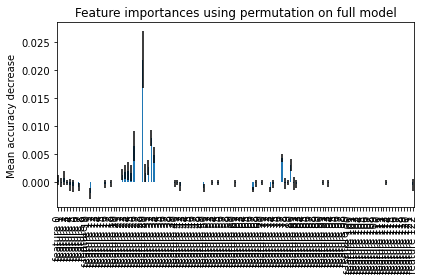

In [275]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    pipe, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

rf_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [279]:
pd.Series(result.importances_mean, index=feature_names)

feature 0      0.00032
feature 1     -0.00016
feature 2      0.00064
feature 3     -0.00016
feature 4     -0.00064
                ...   
feature 118    0.00000
feature 119    0.00000
feature 120    0.00000
feature 121    0.00000
feature 122   -0.00064
Length: 123, dtype: float64

In [289]:
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [292]:
result.importances

array([[ 0.0016,  0.    , -0.0016, ...,  0.    ,  0.    ,  0.0016],
       [ 0.    , -0.0016, -0.0016, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , -0.0016,  0.    , ...,  0.0016,  0.    ,  0.0016],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0016, -0.0016,  0.    , ..., -0.0016, -0.0016,  0.    ]])

In [309]:
pd.Series(result.importances_mean).sort_values(ascending=False).head(10).index

Int64Index([29, 32, 26, 33, 77, 80, 31, 24, 23, 30], dtype='int64')

In [315]:
pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False).head(25).index

Index(['feature 29', 'feature 32', 'feature 26', 'feature 33', 'feature 77',
       'feature 80', 'feature 31', 'feature 24', 'feature 23', 'feature 30',
       'feature 25', 'feature 22', 'feature 2', 'feature 0', 'feature 71',
       'feature 72', 'feature 58', 'feature 59', 'feature 60', 'feature 62',
       'feature 63', 'feature 64', 'feature 65', 'feature 66', 'feature 112'],
      dtype='object')

In [314]:
list(X.iloc[:,pd.Series(result.importances_mean).sort_values(ascending=False).head(25).index].columns)

['recoveries',
 'last_fico_range_high',
 'total_rec_prncp',
 'last_fico_range_low',
 'debt_settlement_flag',
 'last_pymnt_d_rel',
 'last_pymnt_amnt',
 'total_pymnt',
 'out_prncp_inv',
 'collection_recovery_fee',
 'total_pymnt_inv',
 'out_prncp',
 'funded_amnt_inv',
 'loan_amnt',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'addr_state_CA']

In [316]:
list(X.iloc[:,pd.Series(result.importances_mean).sort_values(ascending=False).tail(25).index].columns)

['purpose_moving',
 'addr_state_TX',
 'tax_liens',
 'avg_cur_bal',
 'num_actv_rev_tl',
 'funded_amnt',
 'num_rev_tl_bal_gt_0',
 'title_Credit_card_refinancing',
 'acc_open_past_24mths',
 'percent_bc_gt_75',
 'revol_bal',
 'issue_d_rel',
 'last_credit_pull_d_rel',
 'total_il_high_credit_limit',
 'open_acc',
 'purpose_debt_consolidation',
 'int_rate',
 'grade_ord',
 'installment',
 'bc_open_to_buy',
 'home_ownership',
 'mort_acc',
 'pct_tl_nvr_dlq',
 'total_bc_limit',
 'dti']

Mean Accuracy: nan (nan)
[nan nan nan nan nan]


In [ ]:
#LOGISTIC REGRESSION 

LR_pipe = Pipeline(steps=[
    ('preprocess',ct),
    #('anova', fs),
    ('LR', model)
    #Put PCA here
    #Put Model or feature selection here
])

metric = make_scorer(fbeta_score, beta=2)
%timeit
scores = cross_val_score(LR_pipe, X, y, scoring=metric, cv=cv, n_jobs=-1) 
print('Mean F2 Score: %.3f (%.3f)' % (mean(scores), std(scores)))


In [ ]:
#Build test/train set using train/test split (STRATIFY!) and run kbest to determine most imp features

In [ ]:
# SelectKBest(chi2, k=25).pipe.fit(X, y)

In [ ]:
# define dataset
X, y = load_dataset('pima-indians-diabetes.csv')
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LogisticRegression(solver='liblinear')
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv) # perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

In [ ]:
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


## Samples

In [ ]:
# create numeric transformer 

numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# create categorical stransformer 

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])


# store a list of numeric columns 

numeric_features = train.select_dtypes(include=['int64','float64']).columns


# store a list of categorical columns 
categorical_features = train.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat',categorical_transformer, categorical_features)
])

pipe = Pipeline(steps=[('preprocessor',preprocessor),
                      ('classifier',RandomForestClassifier())])

In [ ]:
for i in range(len(models)):
	# one hot encode categorical, normalize numerical
	ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
	# wrap the model in a pipeline
	pipeline = Pipeline(steps=[('t',ct),('m',models[i])])

In [ ]:
#COLUMN TRANSFORMER

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	# one hot encode cat features only
	ct = ColumnTransformer([('o',OneHotEncoder(),cat_ix)], remainder='passthrough')
	X = ct.fit_transform(X)
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y

In [ ]:
#FEATURE SELECTION

# prepare input data
def prepare_inputs(X_train, X_test):
  oe = OrdinalEncoder()
  oe.fit(X_train)
  X_train_enc = oe.transform(X_train)
  X_test_enc = oe.transform(X_test)
  return X_train_enc, X_test_enc
# prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc
# feature selection
def select_features(X_train, y_train, X_test):
fs = SelectKBest(score_func=mutual_info_classif, k='all') fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
return X_train_fs, X_test_fs, fs


In [ ]:
#SIMPLE IMPUTER

#strategy = 'most_frequent' for mode

# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

#_______________________________________________________________________________________

# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

#_______________________________________________________________________________________


# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
  # create the modeling pipeline
pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', RandomForestClassifier())])
  # evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) # store results
results.append(scores)
print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()


In [ ]:
#KNN IMPUTER

#The key hyperparameter for the KNN algorithm is k; that controls the number of nearest neighbors 
#that are used to contribute to a prediction. It is good practice to test a suite of different values for k. 
#The example below evaluates model pipelines and compares odd values for k from 1 to 21.


# compare knn imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?') # split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
for s in strategies:
    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
      # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) # store results
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

In [ ]:
#ORDINAL ENCODER

# evaluate logistic regression on the breast cancer dataset with an ordinal encoding
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
# load the dataset
dataset = read_csv('breast-cancer.csv', header=None)
# retrieve the array of data
data = dataset.values
# separate into input and output columns
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) # ordinal encode input variables
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)
# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# define the model
model = LogisticRegression()
# fit on the training set    
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat) print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
#ONE HOT ENCODER 

from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# load the dataset
dataset = read_csv('breast-cancer.csv', header=None)
# retrieve the array of data
data = dataset.values
# separate into input and output columns
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) # one-hot encode input variables
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)
# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# define the model
model = LogisticRegression()
# fit on the training set
model.fit(X_train, y_train)
# predict on test set
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

 # Pipeline End

# Testing

In [188]:
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


#H_0 is the data is normally distribute. 
#Alpha = 0.05, since p-value < alpha we reject the null and look for better transforms



# Below are some common values for lambda
# λ = −1.0 is a reciprocal transform.
# λ = −0.5 is a reciprocal square root transform. 
# λ = 0.0 is a log transform.
# λ = 0.5 is a square root transform.
# λ = 1.0 is no transform.

#Run Q-Qs, shaprios, Jarque–Bera, AD, and kstest against boxcox (plain & transformed MinMaxScaler between 1 and 2) and YeoJohnson

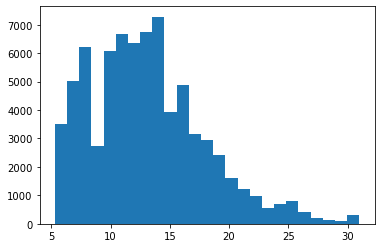

In [126]:
plt.hist(df_jokes['int_rate'],bins=25)
plt.show()

In [ ]:
# generate gaussian data sample
data = randn(1000)
# add a skew to the data distribution
data = exp(data)
# histogram of the raw data with a skew
pyplot.hist(data, bins=25)
pyplot.show()
# reshape data to have rows and columns
data = data.reshape((len(data),1))

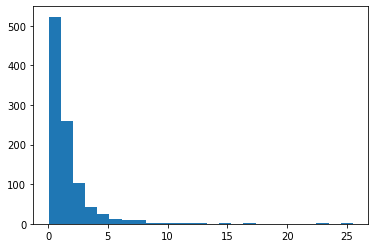

In [136]:
data = np.random.randn(1000)
data = np.exp(data)
plt.hist(data,bins=25)
plt.show()

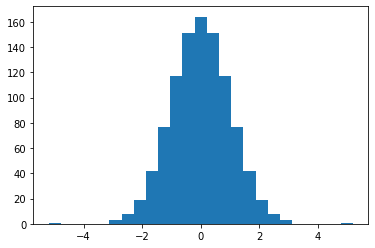

In [152]:

quantile = QuantileTransformer(output_distribution='normal') 
data_trans = quantile.fit_transform(data)
plt.hist(data_trans,bins=25)
plt.show()

<Figure size 432x288 with 0 Axes>

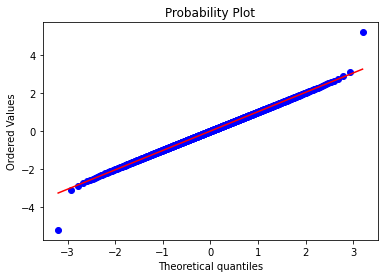

<Figure size 432x288 with 0 Axes>

In [171]:
stats.probplot(data_trans[:,0],plot=plt)
plt.figure()

In [187]:
print(stats.shapiro(data_trans[:,0]))
print(stats.kstest(data_trans[:,0],'norm'))
print(stats.jarque_bera(data_trans[:,0]))
print(stats.anderson(data_trans[:,0],'norm'))
print()


print(np.round(pd.Series(data_trans[:,0]).kurtosis(),4))
print(np.round(pd.Series(data_trans[:,0]).skew(),4))

ShapiroResult(statistic=0.9943155646324158, pvalue=0.0007838233141228557)
KstestResult(statistic=0.0009999000000002756, pvalue=1.0)
Jarque_beraResult(statistic=38.71862538337869, pvalue=3.911626023089809e-09)
AndersonResult(statistic=0.10291555103594874, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

0.9748
0.0


In [146]:
len(df_jokes['int_rate'])

75000

In [149]:
df_jokes['int_rate'].to_numpy().reshape(len(df_jokes['int_rate']),1)

array([[10.99],
       [12.59],
       [14.99],
       ...,
       [11.99],
       [10.99],
       [14.47]])

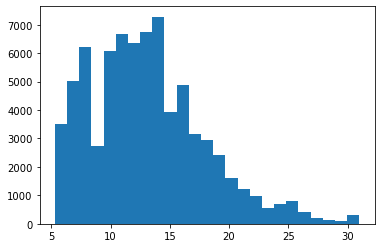

In [174]:
plt.hist(df_jokes['int_rate'],bins=25)
plt.show()

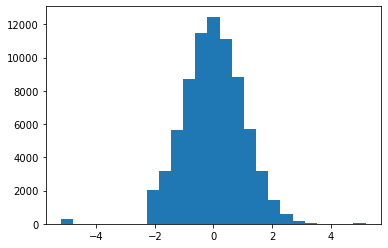

In [172]:
quantile = QuantileTransformer(output_distribution='normal') 
jokes = quantile.fit_transform(df_jokes['int_rate'].to_numpy().reshape(len(df_jokes['int_rate']),1))
# histogram of the transformed data
plt.hist(jokes, bins=25)
plt.show()

<Figure size 432x288 with 0 Axes>

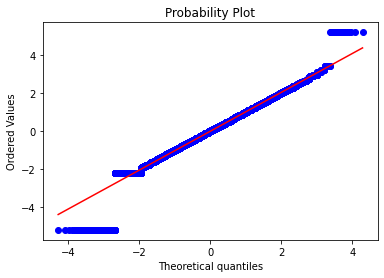

<Figure size 432x288 with 0 Axes>

In [176]:
stats.probplot(jokes[:,0],plot=plt)
plt.figure()

<Figure size 432x288 with 0 Axes>

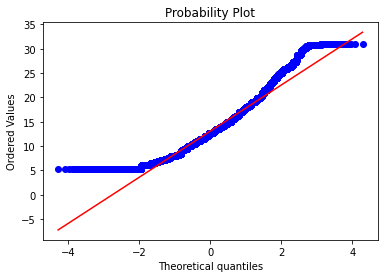

<Figure size 432x288 with 0 Axes>

In [178]:
stats.probplot(df_jokes['int_rate'],plot=plt)
plt.figure()

In [89]:
dir(boxcox(df_jokes['int_rate']))

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

In [107]:
type(df_jokes['int_rate'])

pandas.core.series.Series

In [121]:
print(df_jokes['int_rate'].kurtosis())
print(df_jokes['int_rate'].skew())

0.610962802937423
0.7767048167912294


<Figure size 432x288 with 0 Axes>

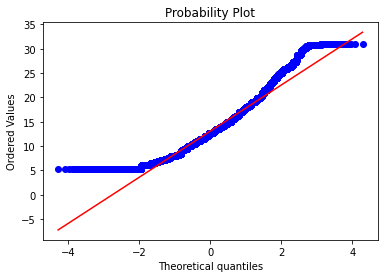

<Figure size 432x288 with 0 Axes>

In [123]:
stats.probplot(df_jokes['int_rate'],plot=plt)
plt.figure()

In [109]:
testz= boxcox(df_jokes['int_rate'])
type(testz)

tuple

In [194]:
print(list(yeojohnson(df_jokes['int_rate']))[0])
print()
print(list(yeojohnson(df_jokes['int_rate']))[1])

[2.77909893 2.93611869 3.14260186 ... 2.87931467 2.77909893 3.10038433]

0.08872837466013946


In [242]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
power_trans = power.fit(df_jokes['int_rate'].to_numpy().reshape(len(df_jokes['int_rate']),1))
print(power_trans.get_params())
np.round(power_trans.lambdas_,4)

{'copy': True, 'method': 'yeo-johnson', 'standardize': True}


array([0.0887])

In [241]:
power = PowerTransformer(method='box-cox', standardize=True)
power_trans = power.fit(df_jokes['int_rate'].to_numpy().reshape(len(df_jokes['int_rate']),1))
print(power_trans.get_params())
np.round(power_trans.lambdas_,4)

{'copy': True, 'method': 'box-cox', 'standardize': True}


array([0.1546])

In [249]:
print(np.round(list(yeojohnson(df_jokes['int_rate']))[1],4))
print(np.round(list(boxcox(df_jokes['int_rate']))[1],4))

0.0887
0.1546


ShapiroResult(statistic=0.9923297762870789, pvalue=0.0)
KstestResult(statistic=0.9716034465436134, pvalue=0.0)
Jarque_beraResult(statistic=537.9974221238936, pvalue=0.0)
AndersonResult(statistic=111.5559952983458, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

-0.4145
-0.0082


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


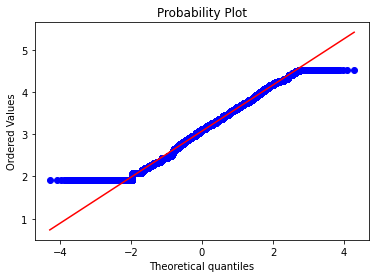

<Figure size 432x288 with 0 Axes>

In [214]:
bc = list(boxcox(df_jokes['int_rate']))[0]
# bc = list(boxcox(df_jokes['int_rate'],lmbda=0))

stats.probplot(bc,plot=plt)
plt.figure()

print(stats.shapiro(bc))
print(stats.kstest(bc,'norm'))
print(stats.jarque_bera(bc))
print(stats.anderson(bc,'norm'))
print()

print(np.round(pd.Series(bc).kurtosis(),4))
print(np.round(pd.Series(bc).skew(),4))

ShapiroResult(statistic=0.9920077919960022, pvalue=0.0)
KstestResult(statistic=0.9773163423117278, pvalue=0.0)
Jarque_beraResult(statistic=573.8800489969672, pvalue=0.0)
AndersonResult(statistic=112.97565144108376, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

-0.4284
-0.0044


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


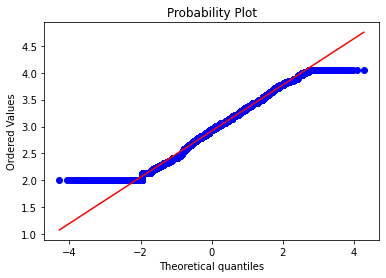

<Figure size 432x288 with 0 Axes>

In [219]:
yj = list(yeojohnson(df_jokes['int_rate']))[0]
# yj = list(yeojohnson(df_jokes['int_rate'],lmbda=0))

stats.probplot(yj,plot=plt)
plt.figure()

print(stats.shapiro(yj))
print(stats.kstest(yj,'norm'))
print(stats.jarque_bera(yj))
print(stats.anderson(yj,'norm'))
print()

print(np.round(pd.Series(yj).kurtosis(),4))
print(np.round(pd.Series(yj).skew(),4))

In [124]:
#H_0 is the data is normally distribute. 
#Alpha = 0.05, since p-value < alpha we reject the null and look for better transforms

print(stats.shapiro(list(boxcox(df_jokes['int_rate'])[0])))


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9923297762870789, pvalue=0.0)

In [114]:
stats.shapiro(list(testz[0]))

ShapiroResult(statistic=0.9923297762870789, pvalue=0.0)

In [102]:
stats.shapiro(df_jokes['int_rate'])

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9592727422714233, pvalue=0.0)

In [104]:
stats.kstest(df_jokes['int_rate'],'norm')

KstestResult(statistic=0.9999999451873826, pvalue=0.0)

In [105]:
stats.jarque_bera(df_jokes['int_rate'])

Jarque_beraResult(statistic=8706.603144174704, pvalue=0.0)

In [22]:
df_jokes = df_clean.copy().sample(75000)

In [25]:
X_jokes = df_jokes.loc[:, df_jokes.columns != 'target']

In [26]:
X_jokes = pd.get_dummies(X_jokes)

In [27]:
y_jokes = df_jokes['target']

In [97]:
SelectKBest(chi2, k=20).fit(X_jokes, y_jokes)

In [250]:
df_clean

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,target,issue_d_rel,earliest_cr_line_rel,last_pymnt_d_rel,last_credit_pull_d_rel
0,3600.0,3600.0,3600.0,36.0,13.99,123.03,C,C4,10.0,MORTGAGE,...,2400.0,13734.0,N,Cash,N,non-default,38.0,186.0,1.0,0.0
1,24700.0,24700.0,24700.0,36.0,11.99,820.28,C,C1,10.0,MORTGAGE,...,79300.0,24667.0,N,Cash,N,non-default,38.0,230.0,32.0,0.0
2,20000.0,20000.0,20000.0,60.0,10.78,432.66,B,B4,10.0,MORTGAGE,...,6200.0,14877.0,N,Cash,N,non-default,38.0,222.0,20.0,0.0
3,35000.0,35000.0,35000.0,60.0,14.85,829.90,C,C5,10.0,MORTGAGE,...,62500.0,18000.0,N,Cash,N,non-default,38.0,125.0,0.0,0.0
4,10400.0,10400.0,10400.0,60.0,22.45,289.91,F,F1,3.0,MORTGAGE,...,20300.0,88097.0,N,Cash,N,non-default,38.0,248.0,31.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247878,24000.0,24000.0,24000.0,60.0,12.79,543.50,C,C1,7.0,MORTGAGE,...,NaN,52017.0,N,Cash,N,non-default,28.0,230.0,0.0,0.0
2247879,24000.0,24000.0,24000.0,60.0,10.49,515.74,B,B3,10.0,MORTGAGE,...,27900.0,172283.0,N,Cash,N,non-default,28.0,336.0,0.0,0.0
2247880,40000.0,40000.0,40000.0,60.0,10.49,859.56,B,B3,9.0,MORTGAGE,...,12300.0,42670.0,N,Cash,N,non-default,28.0,288.0,0.0,0.0
2247881,24000.0,24000.0,24000.0,60.0,14.49,564.56,C,C4,6.0,RENT,...,20700.0,58764.0,N,Cash,Y,default,28.0,235.0,16.0,0.0


# END